Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Taking necessary actions to read the data

### Importing all the important libraries

In [54]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [20]:
## mounting the google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [21]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN/Test')

In [22]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [23]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [24]:

## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
##  resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [25]:
## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing  images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Visualize the data
#### creating a code to visualize one instance of all the nine classes present in the dataset

In [26]:
# Listing out all the classes of skin cancer and store them in a list. 
# finding the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


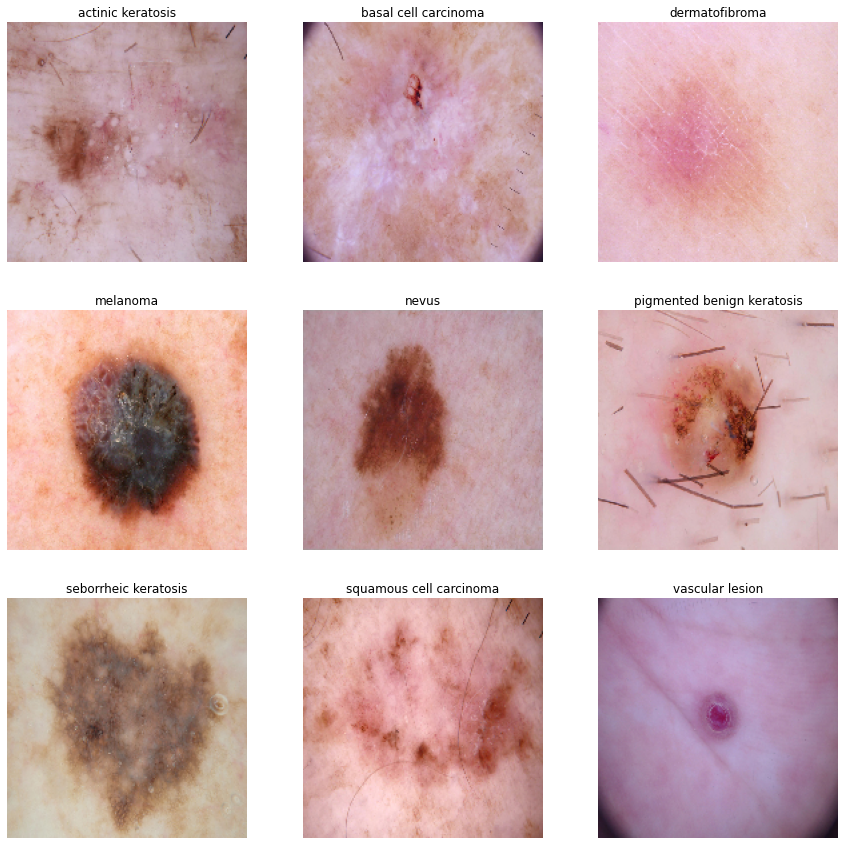

In [27]:
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`


In [29]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [30]:
# Creating layers
input_shape = (180,180,3)

# model architecture
model = Sequential()

#Scaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))

##Second Convulation layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a drop out layer 
model.add(Dropout(0.25))

## third convulation layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

## fourth  convulation layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a drop out layer 
model.add(Dropout(0.25))

#Flatten Layer
model.add(Flatten())

#Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))

#Adding a drop out layer 
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [31]:
# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                      

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [32]:
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
# Viewing the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                      

### Training the model

In [34]:
epochs = 20

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 66ms/step - loss: 2.7694 - accuracy: 0.1925 - val_loss: 2.0504 - val_accuracy: 0.1834
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 2.0524 - accuracy: 0.1942 - val_loss: 2.0313 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 2.0316 - accuracy: 0.1970 - val_loss: 2.0140 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 2.0255 - accuracy: 0.2065 - val_loss: 2.0311 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9784 - accuracy: 0.2377 - val_loss: 2.0040 - val_accuracy: 0.2282
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8931 - accuracy: 0.2863 - val_loss: 1.9510 - val_accuracy: 0.2394
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9124 - accuracy: 0.2701 - val_loss: 1.8369 - val_accuracy: 0.2931
Epoch 8/20
56

### Visualizing training results

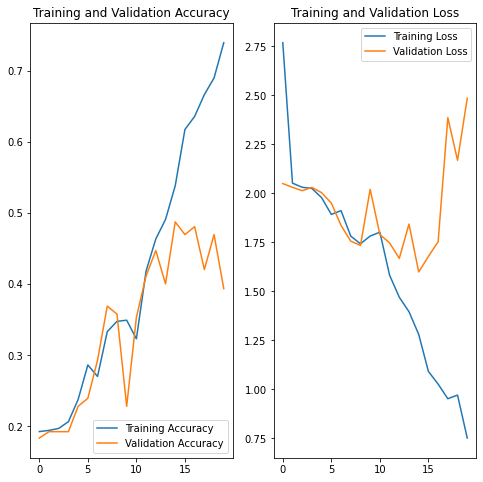

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 16ms/step - loss: 2.4862 - accuracy: 0.3937
Accuracy:  0.7940848469734192
Validation Accuracy:  0.39373600482940674
Loss:  0.6350093483924866
Validation Loss 2.48624324798584


### There is a big difference between Accuracy (79.4%) and Validation Accuracy (39.4%) It is clear that the model is over fitting.

In [37]:
#let us see if the model can predict melanoma correctly
class_names[3]

'melanoma'

/content/gdrive/MyDrive/CNN/Test/melanoma/*
Actual Class melanoma
Predictive Class pigmented benign keratosis


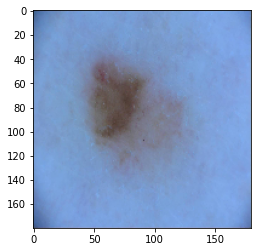

In [38]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
print(Test_image_path)
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[3] +'\n'+ "Predictive Class "+pred_class )

#looks like the prediction is wrong

#### Choosing Data Augumentation strategy

In [39]:
# Let us now apply some modifications to the training images.
datagen = ImageDataGenerator(
    rotation_range=30, fill_mode='nearest',
    width_shift_range=0.2, height_shift_range=0.2,
    brightness_range=[0.4,1.5],
    zoom_range=0.3)

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = batch_size
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = batch_size
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


#### visualizing how augmentation strategy works for one instance of training image.




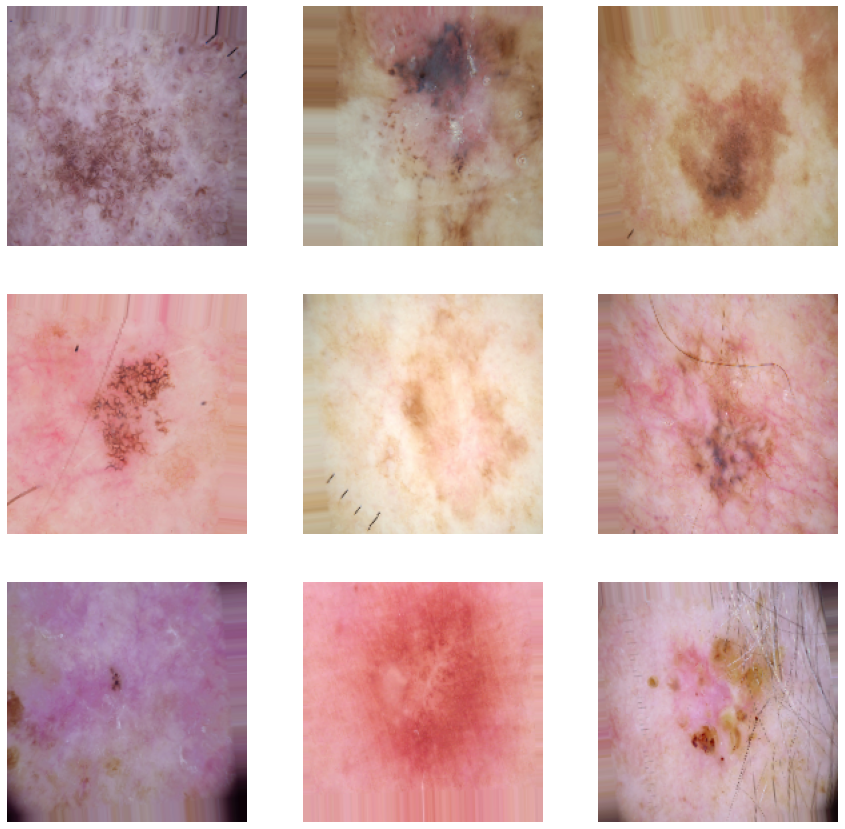

In [117]:
#Visualize first 9 images in training dataset 
image = next(train_batches)[0].astype('uint8')
plt.figure(figsize=(15,15))
index = 0
for i in range(9):
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(image[i])
    plt.axis("off")


### Creating the model, compile and train the model


In [41]:
# Creating layers
input_shape = (180,180,3)

# model architecture
model = Sequential()

#Scaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))


model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [42]:
# summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 178, 178, 32)      0         
                                                      

### Compiling the model

In [43]:
#compling code
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [44]:
epochs = 20
batch_size = 32

history = model.fit(
  train_batches,
  batch_size=batch_size,
  validation_data=valid_batches,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 120s 2s/step - loss: 67.7941 - accuracy: 0.2314 - val_loss: 55.2514 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 56s 796ms/step - loss: 28.1619 - accuracy: 0.1947 - val_loss: 53.7714 - val_accuracy: 0.1441
Epoch 3/20
70/70 [==============================] - 55s 790ms/step - loss: 18.5542 - accuracy: 0.2278 - val_loss: 41.7674 - val_accuracy: 0.1441
Epoch 4/20
70/70 [==============================] - 55s 792ms/step - loss: 12.0257 - accuracy: 0.2407 - val_loss: 27.1608 - val_accuracy: 0.1780
Epoch 5/20
70/70 [==============================] - 55s 790ms/step - loss: 7.9471 - accuracy: 0.2595 - val_loss: 16.9201 - val_accuracy: 0.1441
Epoch 6/20
70/70 [==============================] - 55s 793ms/step - loss: 5.5384 - accuracy: 0.2617 - val_loss: 7.6159 - val_accuracy: 0.1441
Epoch 7/20
70/70 [==============================] - 55s 790ms/step - loss: 4.1970 - accuracy: 0.2345 - val_loss: 4.9884 - val_accuracy:

## Evaluting the model

In [45]:
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 35ms/step - loss: 2.5574 - accuracy: 0.2058
Accuracy:  0.2059151828289032
Validation Accuracy:  0.20581655204296112
Loss:  2.552330493927002
Validation Loss 2.557370901107788


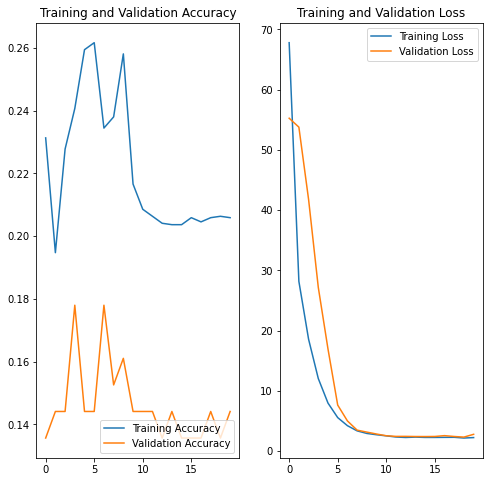

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## While we see that train data and validation data are not very far apart,  We see that accuracy has come down. let us try to update the image transformation that we had applied

In [47]:
# Let us now apply some modifications to the training images.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.1,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images)

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = batch_size
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = batch_size
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [51]:
# Creating layers
input_shape = (180,180,3)

# model architecture
model = Sequential()

#Scaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(num_classes, activation='softmax'))


In [52]:
# summary 
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 41, 41, 128)      

In [55]:
#Let us also add callbacks 
#Stop training when a monitored metric has stopped improving.
stop_v_accuracy = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#adding learning rate to optimer to converse faster.
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#let us also set modify Leanring rate with validating accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

#Compiling the model
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])


## Train the model

In [57]:
epochs = 20
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs,callbacks=[learning_rate_reduction,stop_v_accuracy])

Epoch 1/20
70/70 [==============================] - 54s 771ms/step - loss: 1.2075 - accuracy: 0.5806 - val_loss: 2.5338 - val_accuracy: 0.4153 - lr: 2.5000e-04
Epoch 2/20
70/70 [==============================] - 52s 742ms/step - loss: 1.1139 - accuracy: 0.6025 - val_loss: 2.3751 - val_accuracy: 0.3898 - lr: 2.5000e-04
Epoch 3/20
70/70 [==============================] - 52s 744ms/step - loss: 1.1072 - accuracy: 0.6065 - val_loss: 2.2946 - val_accuracy: 0.4322 - lr: 2.5000e-04
Epoch 4/20
70/70 [==============================] - 52s 742ms/step - loss: 1.0881 - accuracy: 0.6092 - val_loss: 2.3106 - val_accuracy: 0.3814 - lr: 2.5000e-04
Epoch 5/20
70/70 [==============================] - 52s 746ms/step - loss: 1.0760 - accuracy: 0.6150 - val_loss: 2.2050 - val_accuracy: 0.3475 - lr: 2.5000e-04
Epoch 6/20
70/70 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.6190
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
70/70 [=======================

### Visualizing the results

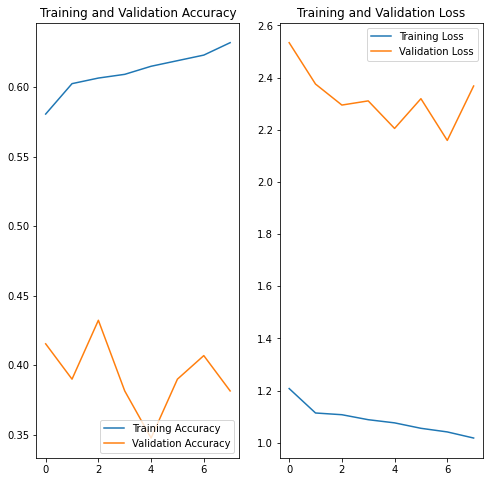

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
loss, accuracy = model.evaluate(train_batches, verbose=1)
loss_v, accuracy_v = model.evaluate(valid_batches, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

4/4 [==============================] - 8s 2s/step - loss: 2.3443 - accuracy: 0.3898
Accuracy:  0.6735149621963501
Validation Accuracy:  0.38983049988746643
Loss:  0.9033735990524292
Validation Loss 2.3442907333374023


#### While the accuracy is better than before it is still less than ideal.
#### The model overfits as well as there is a gap between accuracy and validation accuracy

#### Finding the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [64]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

class_df = class_distribution_count(data_dir_train)
class_df

,Class,No. of Image
0,melanoma,438
1,basal cell carcinoma,376
2,vascular lesion,139
3,dermatofibroma,95
4,squamous cell carcinoma,181
5,pigmented benign keratosis,462
6,actinic keratosis,114
7,seborrheic keratosis,77
8,nevus,357


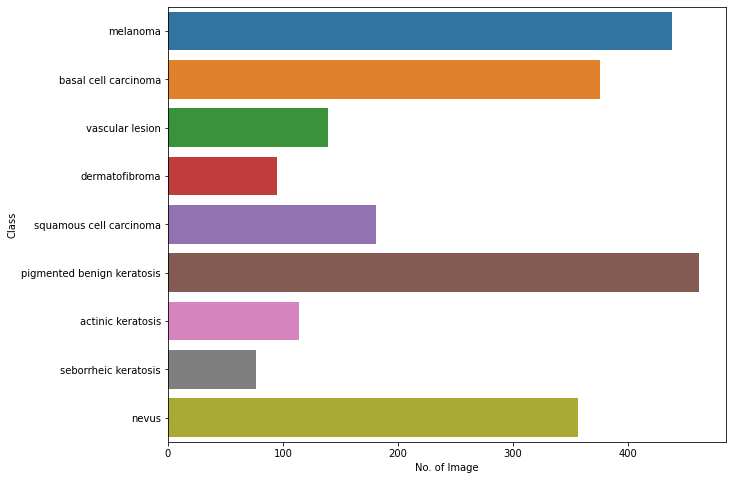

In [69]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **There is a class imbalance:** Findings: 
#### - Which class has the least number of samples? Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples? nevus, pigminted benign keratosis, melenoma & basal cell carcinoma


#### We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [70]:
#install Augmentor
!pip install Augmentor

In [71]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2280544ED0>: 100%|██████████| 500/500 [00:05<00:00, 94.04 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F22802F0510>: 100%|██████████| 500/500 [00:05<00:00, 94.01 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2280329910>: 100%|██████████| 500/500 [00:05<00:00, 96.10 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2216383F10>: 100%|██████████| 500/500 [00:23<00:00, 20.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F22803056D0>: 100%|██████████| 500/500 [00:20<00:00, 23.95 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2280155490>: 100%|██████████| 500/500 [00:05<00:00, 92.46 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F228030A750>: 100%|██████████| 500/500 [00:10<00:00, 49.04 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2280544710>: 100%|██████████| 500/500 [00:05<00:00, 95.23 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2216381450>: 100%|██████████| 500/500 [00:05<00:00, 93.57 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [72]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [74]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0010978.jpg_eac67ce2-97bd-41c0-a2f3-812fe5ea4688.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0010548.jpg_75733af1-488a-4cbe-b9e5-21824f37fba0.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0010803.jpg_3d2a57db-ac3d-4bb0-87d2-7efc0fb2f25d.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_7fe458a8-a7d3-419f-aeb3-d4754737521d.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0000303.jpg_ca389608-4022-4ee2-8f89-dbce810e8d74.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0009868.jpg_7607181f-d389-4bb9-8555-67662197dac7.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0010024.jpg_67c4c181-fb33-4ddc-976d-04c17b061f9a.jpg',
 '/content/gdrive/MyDrive/CNN/Train/melanoma/output/melanoma_original_ISIC_0010054.jpg_800

In [75]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [77]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [78]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [79]:
new_df['Label'].value_counts()


melanoma                      500
basal cell carcinoma          500
vascular lesion               500
dermatofibroma                500
squamous cell carcinoma       500
pigmented benign keratosis    500
actinic keratosis             500
seborrheic keratosis          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [80]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [82]:
data_dir_train="/content/gdrive/MyDrive/CNN/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [83]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating model (Ensuring we include normalization)

In [85]:
# Creating layers
input_shape = (180,180,3)

# model architecture
model = Sequential()

#Scaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 40% Fraction of the input units to drop.
model.add(layers.Dropout(0.4))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(num_classes, activation='softmax'))


In [86]:
# summary of the model
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)       

In [89]:
###choosing an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

## Train model on 50 epochs as mentioned in case snippet provided
However the portal mentioned 30 epochs, not sure which one to use here.

In [90]:
epochs = 50

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 13s 71ms/step - loss: 3.1589 - accuracy: 0.2107 - val_loss: 10.4552 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 12s 69ms/step - loss: 1.9513 - accuracy: 0.2535 - val_loss: 6.3459 - val_accuracy: 0.1188
Epoch 3/50
169/169 [==============================] - 12s 70ms/step - loss: 1.7711 - accuracy: 0.3227 - val_loss: 3.3631 - val_accuracy: 0.2732
Epoch 4/50
169/169 [==============================] - 12s 69ms/step - loss: 1.7379 - accuracy: 0.3448 - val_loss: 1.9774 - val_accuracy: 0.2249
Epoch 5/50
169/169 [==============================] - 12s 69ms/step - loss: 1.5999 - accuracy: 0.3783 - val_loss: 2.4473 - val_accuracy: 0.3103
Epoch 6/50
169/169 [==============================] - 12s 69ms/step - loss: 1.5172 - accuracy: 0.3984 - val_loss: 1.3818 - val_accuracy: 0.4774
Epoch 7/50
169/169 [==============================] - 12s 70ms/step - loss: 1.4025 - accuracy: 0.4566 - val_loss: 1.9854 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


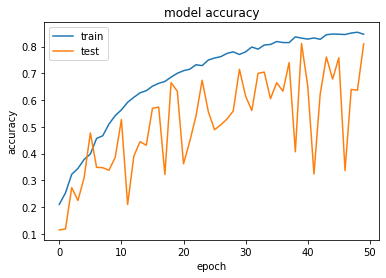

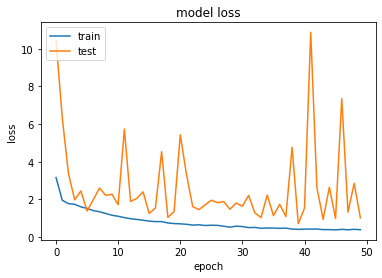

In [92]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Based on the results we see that adjusting for class imbalanced helped in reducing overfit. 

Accuracy = 0.8461
Validation Accuracy = 0.8099
